In [29]:
#Alright - headed into this part of the assignment, you have now created
#your own neural network in a modular fashion, with functions handling
#every step of the network.
#Now we're going to wrap it all together in a single function,
#where we'll solve for all of the backpropogation in one call.

#Setup pieces:
import pickle
import numpy as np
import collections
import copy
import time
from IPython.display import clear_output
from matplotlib import pyplot as plt
%matplotlib inline


with open("testTrainLab2.pickle", "rb") as f:
    labData = pickle.load(f)

y_train = labData["y_train"]
y_test = labData["y_test"]

def preProcessing(train, test, arrayReshape=True, zeroShift=True, zeroShiftVis = True):
    if(zeroShift == True):
        mean_image = np.average(train, axis=0)
        if(zeroShiftVis == True):
            plt.figure(figsize=(4,4))
            plt.imshow(mean_image.reshape((32,32,3)).astype('uint8')) 
            plt.show()
        train -= mean_image
        test -= mean_image

    if(arrayReshape == True):
        train = np.reshape(train, (train.shape[0], -1))
        test = np.reshape(test, (test.shape[0], -1))

    return(train, test)

X_train, X_test = preProcessing(train = labData["X_train"].copy(), 
                                test = labData["X_test"].copy(),
                                arrayReshape = True,
                                zeroShift = True,
                                zeroShiftVis = False)





In [56]:

#Alright - first let's define all of our model parameters in one place. 
#These are all identical to what we did in the "betterNets" case.

modelParametersInit = {}
modelParametersInit['W1'] = np.random.randn(3072, 50) / np.sqrt(3072/2)
modelParametersInit['W2'] = np.random.randn(50, 10) / np.sqrt(50/2)
modelParametersInit['B1'] = np.random.randn(50) / np.sqrt(50/2)
modelParametersInit['B2'] = np.random.randn(10) / np.sqrt(10/2)

#Now let's define our function.
#Any inputs we previously had will need to be parameterized.
#Luckily - it's not too much!
#We need our X image inputs,
#our model weights,
#a y value (for our loss function and backprop - we'll make this optional so
# the function can be used for forward pass as well)), and e - our SVM penalty.
#We'll also add in regularization to this model, with a strength term l.

def twoLayerNet(X, modelParameters, y=None, e = 1.0, l = 1.0):

    W1, W2, B1, B2 = modelParameters['W1'],modelParameters['W2'],modelParameters['B1'],modelParameters['B2']

    N = X.shape[0]
    #Number of dimensions - in this example, 3072 (i.e., each observation has 3072 values)
    D = np.prod(X.shape[1:])
    #Reshape our inputs to be (N,D), matching our expectation for the weights dot product.
    xReshape = np.reshape(X, (N, D))
    
    #Calculate the dot product for the first affine forward pass:
    firstAffine_out = np.dot(xReshape, W1) + B1
    
    #Calculate the maximum for the relu activation
    reluOut = np.maximum(firstAffine_out, 0)

    #Second affine
    N = reluOut.shape[0]
    D = np.prod(reluOut.shape[1:])
    xReshape = np.reshape(reluOut, (N,D))
    estimatedScores = np.dot(xReshape, W2) + B2
    
    #And, we're done with the forward pass!  If y = none, we're done entirely,
    #as this is just a forward request.
    if(y is None):
        return(estimatedScores)

#And - viola, we get our 10 score values out.
forwardPass = twoLayerNet(X = X_train[0:1], modelParameters = modelParametersInit)
print(forwardPass)

[[ -79.88963117   25.67890977  -67.18794062  -28.26654095   -3.55766936
  -104.00176804   -0.229145    -40.46070174   52.91216647   85.7739902 ]]


In [60]:
#Now, let's add in the backward pass.  After this, we would be ready to adjust our modelParameters by simply looping over this function.

def twoLayerNet(X, modelParameters, y=None, e = 1.0, l = 1.0):

    W1, W2, B1, B2 = modelParameters['W1'],modelParameters['W2'],modelParameters['B1'],modelParameters['B2']

    N = X.shape[0]
    D = np.prod(X.shape[1:])
    xReshapeAffineA = np.reshape(X, (N, D))
    firstAffine_out = np.dot(xReshapeAffineA, W1) + B1
    
    reluOut = np.maximum(firstAffine_out, 0)

    N = reluOut.shape[0]
    D = np.prod(reluOut.shape[1:])
    xReshapeAffineB = np.reshape(reluOut, (N,D))
    estimatedScores = np.dot(xReshapeAffineB, W2) + B2

    if(y is None):
        return(estimatedScores)

    else:
        #Calculate the loss - take a look back at the last assignment step for all of the details on this!
        N = estimatedScores.shape[0]
        correctClassScore = estimatedScores[np.arange(N), y]
        margin = np.maximum(0, estimatedScores-correctClassScore[:,np.newaxis] + e)
        margin[np.arange(N), y] = 0

        loss = np.sum(margin)

        #Add our regularization loss in.
        #There are many more effecient ways to do this,
        #but we're writing it out in long form for ease of interpretation here.
        #Arbitrarily using L1 Reg
        regLoss =  np.sum(np.abs(modelParameters['B1']))
        regLoss += np.sum(np.abs(modelParameters['B1']))
        regLoss += np.sum(np.abs(modelParameters['W1']))
        regLoss += np.sum(np.abs(modelParameters['W2']))

        loss = loss + l * regLoss

        #Solve for the overall percent correct.
        #This is optional, and really just for visualization
        correct = np.mean(np.equal(correctClassScore, np.amax(estimatedScores, axis=1)))

        #Gradient for Scores vs. Loss
        positiveCount = np.sum(margin>0, axis=1)
        dx = np.zeros_like(estimatedScores)
        dx[margin > 0] = 1
        dx[np.arange(N), y] -= positiveCount
        dx /= N

        #Gradient that is sent to Relu:
        N = xReshapeAffineB.shape[0]
        dh = np.reshape(np.dot(dx, W2.T), xReshapeAffineB.shape)
        dw2 = np.dot(xReshapeAffineB.T, dx)
        db2 = np.dot(dx.T, np.ones(N))

        #Gradient that is sent to first Affine:
        d_affineA = np.array(dh, copy=True)
        d_affineA[firstAffine_out <= 0] = 0
    
        #Final Affine
        N = xReshapeAffineA.shape[0]
        dh = np.reshape(np.dot(d_affineA, W1.T), xReshapeAffineA.shape)
        dw1 = np.dot(xReshapeAffineA.T, d_affineA)
        db1 = np.dot(d_affineA.T, np.ones(N))

        grads = {}
        grads['W1'] = dw1
        grads['W2'] = dw2
        grads['B1'] = db1
        grads['B2'] = db2
        return(loss, grads, correct)

fullPass = twoLayerNet(X = X_train[0:1], y = y_train[0:1], modelParameters = modelParametersInit)
print("Loss: " + str(fullPass[0]))
print("Gradient of W2 (example): \n" + str(fullPass[1]['W2']))
 

Loss: 3401.9690119760476
Gradient of W2 (example): 
[[   0.            0.            0.            0.            0.
     0.            0.            0.            0.            0.        ]
 [   0.            0.            0.            0.            0.
     0.            0.            0.            0.            0.        ]
 [   0.            0.            0.            0.            0.
     0.            0.            0.            0.            0.        ]
 [   0.           73.86954425    0.            0.            0.
     0.         -221.60863276    0.           73.86954425   73.86954425]
 [   0.            0.            0.            0.            0.
     0.            0.            0.            0.            0.        ]
 [   0.           67.50058448    0.            0.            0.
     0.         -202.50175344    0.           67.50058448   67.50058448]
 [   0.           72.36712419    0.            0.            0.
     0.         -217.10137256    0.           72.36712419   72

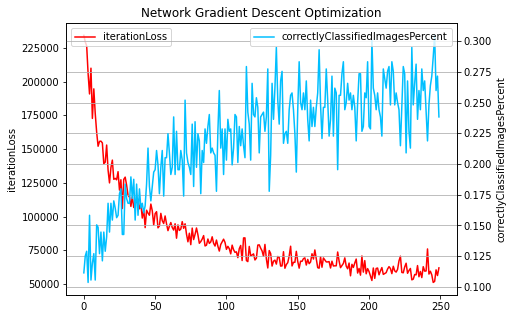

In [83]:
#Let's give a quick fit a shot and see how this performs.
#It *should* be fairly similar to what we've seen before,
#Though I encourage you to play with depth and other options.

#Note even with this very (very) simple model, it is possible to get over 30-35% accuracy with enough training.

#Function for visualizing:
def plotFit(plotData, figsize=(7,5), title=''):
        clear_output(wait=True)
        plt.figure(figsize=figsize)
        i = 0
        colors = ['red', 'deepskyblue', 'orange', 'green']
        loc = ['upper left', 'upper right', 'lower left', 'lower right']
        for label,data in plotData.items():
            plt.plot(data, label=label, color=colors[i])
            plt.ylabel(label)
            plt.legend(loc = loc[i])
            if(i == 0):
                plt.twinx()
            i = i + 1
        plt.title(title)
        plt.grid(True)
        plt.xlabel('Iteration')
        plt.show()


plotData = {}
plotData['iterationLoss'] = []
plotData['correctlyClassifiedImagesPercent'] = []

#Our entire fit is now much shorter!  Compare to our loop back in section 3.
currentIteration = 0
batchSize = 512
learningRate = .00001
maxIterations = 250

modelParameters = {}
modelParameters['W1'] = np.random.randn(3072, 50) / np.sqrt(3072/2)
modelParameters['W2'] = np.random.randn(50, 10) / np.sqrt(50/2)
modelParameters['B1'] = np.random.randn(50) / np.sqrt(50/2)
modelParameters['B2'] = np.random.randn(10) / np.sqrt(10/2)

while currentIteration < maxIterations:
    randomSelection = np.random.randint(len(X_train), size=batchSize)
    xBatch = X_train[randomSelection,:]
    yBatch = y_train[randomSelection]

    iterationModel = twoLayerNet(X = xBatch, y = yBatch, modelParameters = modelParameters)
    plotData['iterationLoss'].append(iterationModel[0])
    plotData['correctlyClassifiedImagesPercent'].append(iterationModel[2])


    modelParameters['W1'] += -learningRate * iterationModel[1]['W1']
    modelParameters['W2'] += -learningRate * iterationModel[1]['W2']
    modelParameters['B1'] += -learningRate * iterationModel[1]['B1']
    modelParameters['B2'] += -learningRate * iterationModel[1]['B2']

    currentIteration = currentIteration + 1

plotFit(plotData = plotData, title="Network Gradient Descent Optimization")
